In [40]:
import os
import polars as pl
import duckdb
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import psutil

# Warmup

In [2]:
base_path = "leash-BELKA"

In [6]:
# Lazily read the parquet file and select the first 10 rows
pd_train_head = pl.scan_parquet(os.path.join(base_path, "train.parquet")).fetch(10)
pd_train_head.head()

C:\Users\predator\AppData\Local\Temp\ipykernel_17180\1844886930.py:2: DeprecationWarning: `LazyFrame.fetch` is deprecated. `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  pd_train_head = pl.scan_parquet(os.path.join(base_path, "train.parquet")).fetch(10)


id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
i64,str,str,str,str,str,i64
0,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""BRD4""",0
1,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""HSA""",0
2,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""sEH""",0
3,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.NCc1cccc(Br)n1""","""C#CCOc1ccc(CNc2nc(NCc3cccc(Br)…","""BRD4""",0
4,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.NCc1cccc(Br)n1""","""C#CCOc1ccc(CNc2nc(NCc3cccc(Br)…","""HSA""",0


In [8]:
# Connect to DuckDB and read only the first 10 rows
con = duckdb.connect()
sql_stm = f"""
    SELECT * 
    FROM parquet_scan('{os.path.join(base_path, 'train.parquet')}')
    LIMIT 10
"""
pd_train_head = con.execute(sql_stm).df()
pd_train_head.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


# Benchmark 1: counting

In [61]:
# Helper function to get memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024**2)  # Convert bytes to MB


# Function to benchmark Polar
def benchmark_polars(file_path):
    start_time = time.time()
    mem_before = get_memory_usage()

    # Use lazy frame for efficient loading and filtering
    if "parquet" in file_path:
        lazy_df = pl.scan_parquet(file_path)
    else:
        lazy_df = pl.scan_csv(file_path)

    # Execute query where 'binds' equals 1
    total_count = lazy_df.filter(pl.col("binds") == 0).select(pl.len()).collect()[0, 0]

    elapsed_time = time.time() - start_time
    mem_consumed = abs(get_memory_usage() - mem_before)

    return elapsed_time, mem_consumed, total_count


# Function to benchmark DuckDB
def benchmark_duckdb(file_path):
    start_time = time.time()
    mem_before = get_memory_usage()

    con = duckdb.connect()

    # Query using DuckDB's lazy loading and efficient memory handling
    if "parquet" in file_path:
        result = con.execute(
            f"SELECT COUNT(*) FROM parquet_scan('{file_path}') WHERE binds=0"
        ).fetchone()
    else:
        result = con.execute(
            f"SELECT COUNT(*) FROM read_csv_auto('{file_path}') WHERE binds=0"
        ).fetchone()
    total_count = result[0]

    elapsed_time = time.time() - start_time
    mem_consumed = abs(get_memory_usage() - mem_before)
    return elapsed_time, mem_consumed, total_count

## Polar on parquet

In [42]:
%%timeit -n 1 -r 3

# checking function
runtime, mem, result = benchmark_polars(os.path.join(base_path, "train.parquet"))
print("Time:", runtime)
print("RAM:", mem)
print("Number of records:", result)

Time: 0.6784224510192871
RAM: 1336.57421875
Number of records: 293656924
Time: 0.4804725646972656
RAM: 38.4140625
Number of records: 293656924
Time: 0.4731011390686035
RAM: 13.171875
Number of records: 293656924
544 ms ± 94.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Polar on csv

In [43]:
%%timeit -n 1 -r 1

# checking function
runtime, mem, result = benchmark_polars(os.path.join(base_path, "train.csv"))
print("Time:", runtime)
print("RAM:", mem)
print("Number of records:", result)

Time: 40.44319295883179
RAM: -1345.25390625
Number of records: 293656924
40.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## DuckDB on parquet

In [44]:
%%timeit -n 1 -r 3

# checking function
runtime, mem, result = benchmark_duckdb(os.path.join(base_path, "train.parquet"))
print("Time:", runtime)
print("RAM:", mem)
print("Number of records:", result)

Time: 0.23084068298339844
RAM: 22.390625
Number of records: 293656924
Time: 0.15899276733398438
RAM: 1.1875
Number of records: 293656924
Time: 0.1691288948059082
RAM: 1.078125
Number of records: 293656924
189 ms ± 31.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## DuckDB on CSV

In [45]:
%%timeit -n 1 -r 1

# checking function
runtime, mem, result = benchmark_duckdb(os.path.join(base_path, "train.csv"))
print("Time:", runtime)
print("RAM:", mem)
print("Number of records:", result)

Time: 39.56442713737488
RAM: 31.51953125
Number of records: 293656924
39.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Start benchmark

In [53]:
### Run the benchmarks multiple times and store results ###
def run_benchmarks(parquet_file, n_runs=5, is_polar=True):
    results = []
    for i in tqdm(range(n_runs)):
        if is_polar:
            # Run Polars benchmark
            runtime, mem, result = benchmark_polars(parquet_file)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "Polars Time": runtime,
                    "Polars Memory (MB)": mem,
                }
            )
        else:
            # Run DuckDB benchmark
            runtime, mem, result = benchmark_duckdb(parquet_file)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "DuckDB Time": runtime,
                    "DuckDB Memory (MB)": mem,
                }
            )

    return results

In [68]:
def plot_results(df_output, title1, title2):
    # Plot the benchmark times for comparison
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(
        df_output["Run"], df_output["Polars Time"], label="Polars Time", marker="s"
    )
    plt.plot(
        df_output["Run"], df_output["DuckDB Time"], label="DuckDB Time", marker="^"
    )
    plt.title(title1)
    plt.xlabel("Run")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(
        df_output["Run"],
        df_output["Polars Memory (MB)"],
        label="Polars Memory",
        marker="s",
    )
    plt.plot(
        df_output["Run"],
        df_output["DuckDB Memory (MB)"],
        label="DuckDB Memory",
        marker="^",
    )
    plt.title(title2)
    plt.xlabel("Run")
    plt.ylabel("Memory Usage (MB)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Parquet benchmark

In [62]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.parquet"), n_runs=50)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


In [63]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.parquet"), n_runs=50, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


In [64]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,0.485283,19.800781,0.171429,0.761719
1,2,0.475586,24.621094,0.175919,0.500000
2,3,0.487367,36.535156,0.171425,0.320312
3,4,0.514384,19.093750,0.171201,0.742188
4,5,0.489365,11.980469,0.170430,0.425781


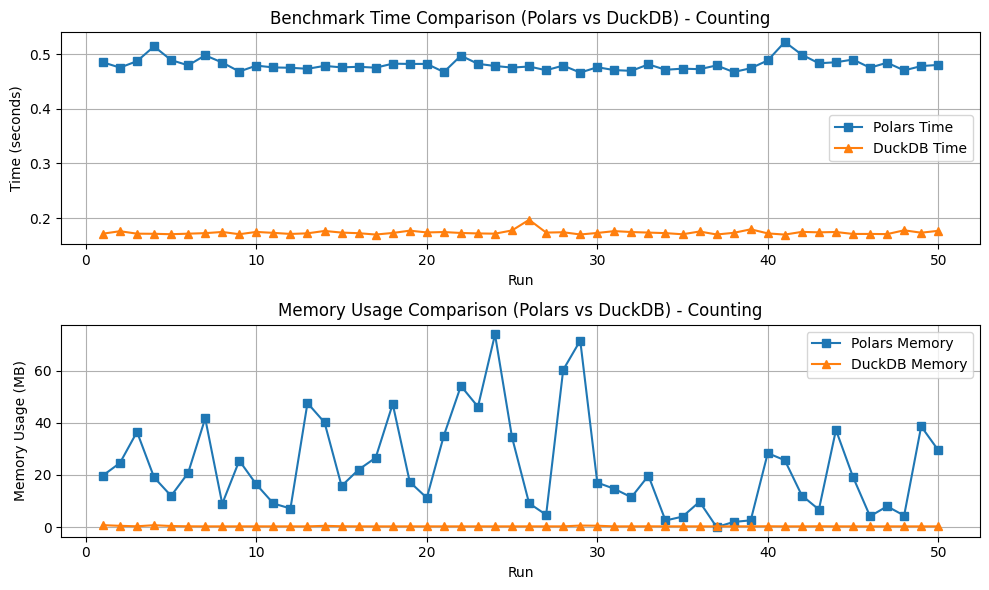

In [70]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - Counting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - Counting"
plot_results(df_results, title1, title2)

## CSV benchmark

In [ ]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.csv"), n_runs=5)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


In [ ]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.csv"), n_runs=5, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


In [ ]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,0.485283,19.800781,0.171429,0.761719
1,2,0.475586,24.621094,0.175919,0.500000
2,3,0.487367,36.535156,0.171425,0.320312
3,4,0.514384,19.093750,0.171201,0.742188
4,5,0.489365,11.980469,0.170430,0.425781


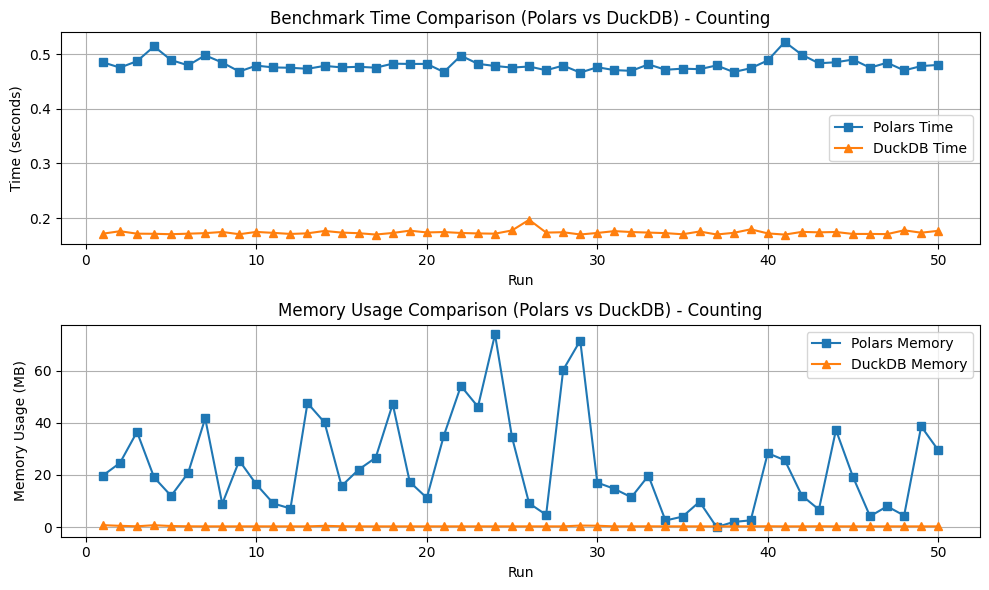

In [ ]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - Counting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - Counting"
plot_results(df_results, title1, title2)